In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12
plt.rcParams.update({
    "text.usetex": True,
})

In [2]:
def load_data(path):
    """ read in excel sheets
        grab all .xlsx files in the dir specified by path """
    files_under_path = os.listdir(path)
    fnames = [f[:-5] for f in files_under_path if f.endswith('.xlsx')]

    all_files = {}
    for i in range(len(fnames)):
        file = pd.read_excel(f'{path}/{fnames[i]}.xlsx', sheet_name=None, engine='openpyxl')
        all_files[fnames[i]] = file

    return fnames, all_files


def get_common_sheet_names(all_files):
    """ find the sheet names that are common to all files """
    # initialize common sheet names with the first file's sheets names
    common_sheet_names = set(all_files[list(all_files.keys())[0]].keys()) 
    for k in all_files.keys():
        common_sheet_names = common_sheet_names.intersection(set(all_files[k].keys()))
    common_sheet_names = sorted(list(common_sheet_names))
    return common_sheet_names

In [3]:
def get_unique_sheet_names(file, common_sheet_names):
    """ find the sheet names that are unique to each file """
    unique_sheet_names = set(file.keys()).difference(set(common_sheet_names))
    return sorted(list(unique_sheet_names))
    

In [4]:
def func_count(df, fname, sheet_name, output_dir, save=True, actuall_run = False):
    """ Count how many times each function is used """
    # get the elements with first column value = 'y'; 
    # when actuall_run = True, get the elements with first column value = 'y' only
    
    cols = df.columns
    if len(cols) == 0:
        with open(f'{output_dir}/log.txt', 'a') as f:
            f.write(f'{fname}: {sheet_name} - empty file\n\n')
        return None
    
    if not actuall_run:
        filt = (df[cols[0]] == 'y') | (df[cols[0]] == 'n')
    else:
        filt = (df[cols[0]] == 'y')
    
    if ('SampleStartLayoutAssembler' in cols) and (filt.sum() > 0):
        df_funcs = df[filt]['SampleStartLayoutAssembler']
        df_count = df_funcs.value_counts().reset_index()
        df_count.columns = ['func_name', 'count']
        # sort by count
        df_count = df_count.sort_values(by='count', ascending=False)
        df_count['file_name'] = fname
        df_count['sheet_name'] = sheet_name

        # save to csv
        # check if the file exists
        if save:
            if os.path.exists(f'{output_dir}/func_count.csv'):
                print('writing to existing file')
                df_count.to_csv(f'{output_dir}/func_count.csv', index=False, mode = 'a', header=False)
            else:
                print('new file created')
                # create the file
                with open(f'{output_dir}/func_count.csv', 'w') as f:
                    f.write('func_name,count,file_name,sheet_name\n')
                df_count.to_csv(f'{output_dir}/func_count.csv', index=False, mode = 'a', header=False)
            
            # log file
            now = datetime.datetime.now()
            date = now.strftime("%y%m%d-%H%M%S")
            with open(f'{output_dir}/log.txt', 'a') as f:
                f.write(f"date: {date}\n")
                f.write(f'{fname}: {sheet_name} - {df_count.shape[0]} function(s) counted\n\n')
            print(f'saved to {output_dir}/func_count.csv\n')

        return df_count
    
    else:
        return None


In [5]:
def count_all(input_path,save,actuall_run):
    """used if all files in the directory have the same sheet names"""
    # define dataframes
    fnames, all_files = load_data(input_path)
    common_sheet_names = get_common_sheet_names(all_files)

    list_of_dfs = []
    for fname in fnames:
        for sheet_name in common_sheet_names:
            df_sheet = all_files[fname][sheet_name]  # a single sheet
            df_count = func_count(df_sheet, fname, sheet_name, output_dir = input_path, save=save, actuall_run = actuall_run)
            list_of_dfs.append(df_count)

    # concatenate all dataframes
    df = pd.concat(list_of_dfs)
    # remove row index
    df.reset_index(drop=True, inplace=True)
    return df
      


In [6]:
def count_individual(input_path,save,actuall_run):
    
    # define dataframes
    fnames, all_files = load_data(input_path)

    list_of_dfs = []
    for fname in fnames:
        sheet_names = all_files[fname].keys()
        for sheet_name in sheet_names:
            df_sheet = all_files[fname][sheet_name]  # a single sheet in a single file
            df_count = func_count(df_sheet, fname, sheet_name, output_dir = input_path, save=save, actuall_run = actuall_run)
            list_of_dfs.append(df_count)

    # remove empty data frames
    list_of_dfs = [x for x in list_of_dfs if x is not None]
    # concatenate all dataframes
    df = pd.concat(list_of_dfs)
    # remove row index
    df.reset_index(drop=True, inplace=True)
    return df
      

In [31]:
def most_popular_func(path):
    df = count_individual(path,save=False,actuall_run=True)
    pop_rank = df.groupby(['func_name'])['count'].sum().sort_values(ascending=False).reset_index()
    return pop_rank

def plot_pop_func(pop_rank, title='Most Popular Functions'):
    plt.figure()
    sns.barplot(x='count', y='func_name', data=pop_rank, palette='viridis', hue='func_name', legend=False)
    plt.xlabel('Count')
    plt.ylabel('Function Name')
    plt.title(title)
    plt.tight_layout()
    # plt.savefig('most_popular_func.png', dpi=300)
    plt.show()
    return None

# example: 1227

In [7]:
# (*) count all files in the directory
# Data cleaning: getting their func call frequencies; keep files and sheets separate
df1227 = count_individual(input_path = '../input_sheets/1227', save = False, actuall_run = True)

In [8]:
df1227

,func_name,count,file_name,sheet_name
0,StartLayoutAssembler,1,canon_1227_d3t4_jm2_siv_2x,canon
1,StartLayoutAssembler,11,canon_1227_d3t4_jm2_siv_2x,all_marks
2,xy_canon,10,canon_1227_d3t4_jm2_siv_2x,all_marks
3,create_instance,8,canon_1227_d3t4_jm2_siv_2x,all_marks
4,shape_size,5,canon_1227_d3t4_jm2_siv_2x,all_marks
...,...,...,...,...
181,StartLayoutAssembler,1,canon_lunarlake_psm_final_1,box_box
182,StartLayoutAssembler,4,canon_lunarlake_psm_final_1,FA_short
183,fa_canon,4,canon_lunarlake_psm_final_1,FA_short
184,StartLayoutAssembler,4,canon_lunarlake_psm_final_1,cross


In [9]:
# count how many functions are called in each file
df1227.groupby('file_name')['count'].sum().sort_values(ascending=False)

file_name
canon_1227_d3t7_jm5_siv_2x     158
canon_1227_d3t4_jm2_siv_2x     149
canon_1227_gms_siv_2x           91
canon_1227_gmb_siv_2x           71
canon_lunarlake_psm_final_1     41
canon_1227_d3t7_psv             34
Name: count, dtype: int64

In [10]:
# count how many functions are called in each sheet
df1227.groupby('sheet_name')['count'].sum().sort_values(ascending=False)

sheet_name
all_marks              94
parents                60
review                 43
place_conatiners       40
swirl_xy4              30
review_parent          26
xy4                    22
psm_containers         20
FA_short               16
cross                  16
gms_siv_swirl_xy4      15
gmb_siv_swirl_xy4      15
swirl_hatch            14
swirl_cross            14
diag_dummy             14
gmb_xy4                12
dummy_beard            11
gmb_siv_swirl_cross     7
gmb_siv_swril_hatch     7
gms_siv_swirl_cross     7
gms_siv_swril_hatch     7
box_box                 6
gms_xy4                 6
hatch                   6
pound                   6
dummy_filler            6
canon                   4
gmb_hatch               4
kga                     4
gmb_pound               4
gms_pound               2
zonal_bkg               2
gms_hatch               2
gmb_zonal_bkg           1
gms_zonal_bkg           1
Name: count, dtype: int64

In [11]:
# count in each file what are the most called functions
pop_rank_file = df1227.groupby(['file_name', 'func_name'])['count'].sum().sort_values(ascending=False).reset_index()

In [12]:
pop_rank_file.head(20)

,file_name,func_name,count
0,canon_1227_d3t7_jm5_siv_2x,create_instance,43
1,canon_1227_d3t7_jm5_siv_2x,StartLayoutAssembler,41
2,canon_1227_d3t4_jm2_siv_2x,create_instance,40
3,canon_1227_d3t4_jm2_siv_2x,StartLayoutAssembler,38
4,canon_1227_gms_siv_2x,create_instance,33
5,canon_1227_gms_siv_2x,StartLayoutAssembler,31
6,canon_1227_gmb_siv_2x,StartLayoutAssembler,21
7,canon_lunarlake_psm_final_1,StartLayoutAssembler,20
8,canon_1227_d3t4_jm2_siv_2x,xy_canon,20
9,canon_1227_d3t7_jm5_siv_2x,xy_canon,20


In [13]:
# count in all files what are the most called functions
pop_rank_all = df1227.groupby(['func_name'])['count'].sum().sort_values(ascending=False).reset_index()

In [14]:
pop_rank_all.head(10)

,func_name,count
0,StartLayoutAssembler,162
1,create_instance,139
2,xy_canon,62
3,AddToCluster,30
4,shape_size,30
5,tvpa_canon,20
6,zonal_background,18
7,chopped_tvpa_canon,18
8,bool_and_not,17
9,create_rectangle,17


In [16]:
paths = ['../input_sheets/1227', '../input_sheets/1276', '../input_sheets/1278', '../input_sheets/1280','../input_sheets/1282']

In [17]:
print(most_popular_func(paths[4]).head(10))

              func_name  count
0  StartLayoutAssembler     99
1       create_instance     85
2              xy_canon     42
3          AddToCluster     20
4    chopped_tvpa_canon     12
5          bool_and_not     12
6            shape_size     10
7            tvpa_canon     10
8      zonal_background      9
9       create_gratings      5


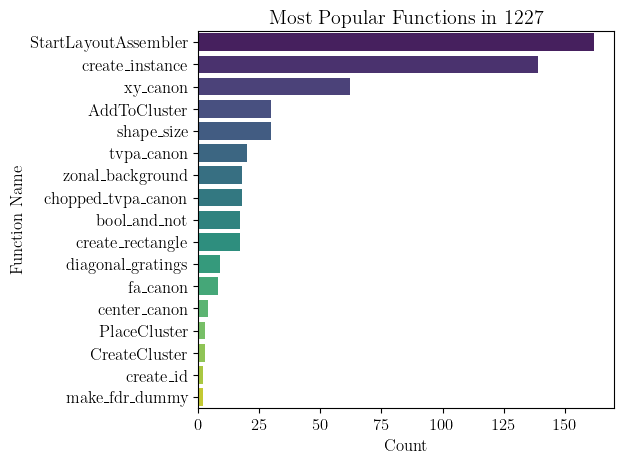

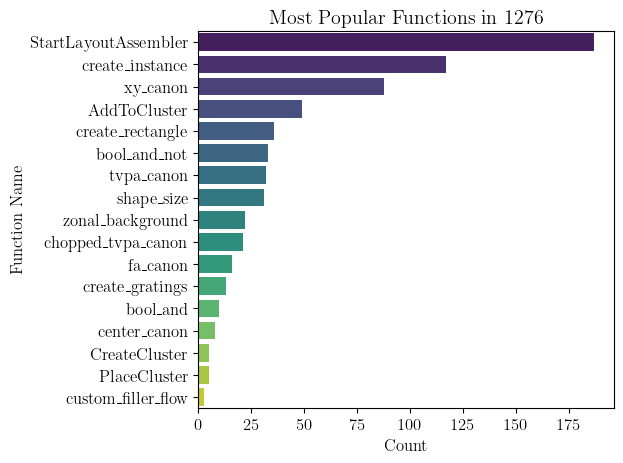

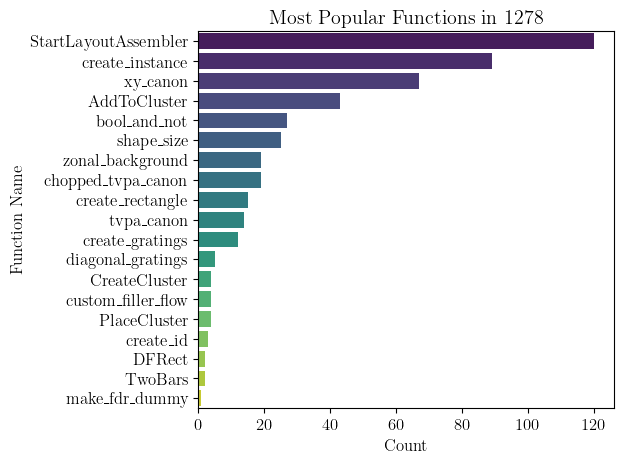

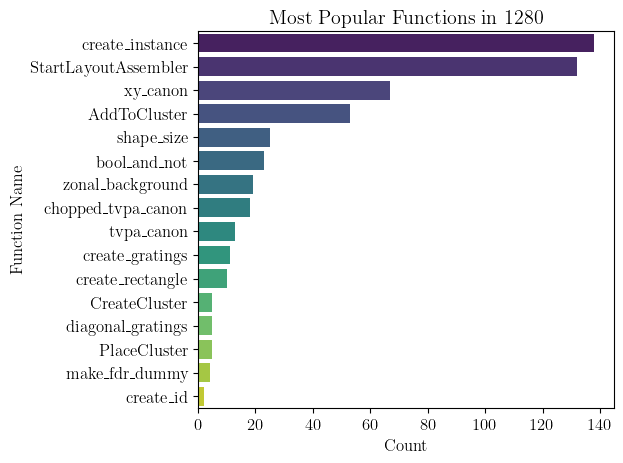

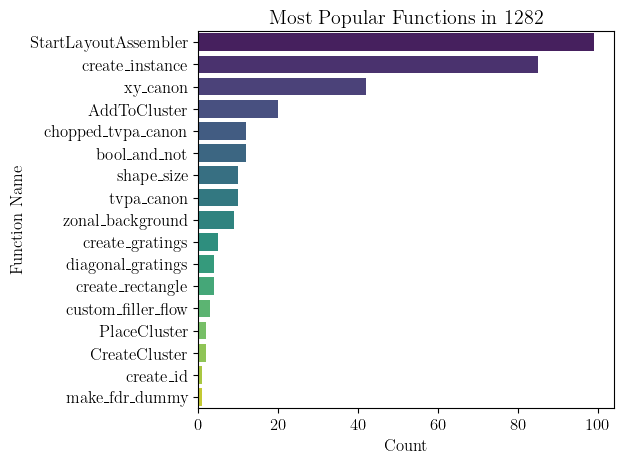

In [33]:
for path in paths:
    plot_pop_func(most_popular_func(path), title=f'Most Popular Functions in {path[-4:]}')